In [ ]:
!pip install -q datasets
!pip install -q pandas
!pip install -q transformers
!pip install -q tensorflow
!pip install -q huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
from datasets import load_dataset
from huggingface_hub import notebook_login

In [ ]:
notebook_login()

In [ ]:
#tokenizer = AutoTokenizer.from_pretrained("bert-base-unc3ased")
#model = TFAutoModel.from_pretrained("bert-base-uncased",)
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")
model = TFAutoModel.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased",)

Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
instrucciones = load_dataset('cbasconc/instructions_Device')


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
instrucciones

DatasetDict({
    train: Dataset({
        features: ['text', 'label_text', 'label'],
        num_rows: 495
    })
    test: Dataset({
        features: ['text', 'label_text', 'label'],
        num_rows: 213
    })
})

In [ ]:
instrucciones.

In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)
datos_encoded = instrucciones.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/807 [00:00<?, ? examples/s]

Map:   0%|          | 0/202 [00:00<?, ? examples/s]

In [ ]:
datos_encoded.set_format('tf',
                         columns=['input_ids', 'attention_mask', 'token_type_ids', 'label'])

# setting BATCH_SIZE to 64.
BATCH_SIZE = 15

def order(inp):
    data = list(inp.values())
    return {
        'input_ids': data[1],
        'attention_mask': data[2],
        'token_type_ids': data[3]
    }, data[0]

# converting train split of `emotions_encoded` to tensorflow format
train_dataset = tf.data.Dataset.from_tensor_slices(datos_encoded['train'][:])
# set batch_size and shuffle
train_dataset = train_dataset.batch(BATCH_SIZE).shuffle(1000)
# map the `order` function
train_dataset = train_dataset.map(order, num_parallel_calls=tf.data.AUTOTUNE)

# ... doing the same for test set ...
test_dataset = tf.data.Dataset.from_tensor_slices(datos_encoded['test'][:])
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.map(order, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
inp, out = next(iter(train_dataset)) # a batch from train_dataset
print(inp, '\n\n', out)

{'input_ids': <tf.Tensor: shape=(15, 13), dtype=int64, numpy=
array([[    4,  9231,  2941,  2391, 24228,  1074,  2452,  1076,  7259,
            5,     1,     1,     1],
       [    4,  4999,  1551, 30960,  1149,  2174,  2079,     5,     1,
            1,     1,     1,     1],
       [    4,  4902,  1190,  1607,  1074, 10335,  1076,  7259,     5,
            1,     1,     1,     1],
       [    4, 18811,  2391, 24968,  1074,  2452,  1076,  7259,     5,
            1,     1,     1,     1],
       [    4,  3070,  4638, 24968,     5,     1,     1,     1,     1,
            1,     1,     1,     1],
       [    4,  9231,  2366,  1081,  2079, 16268,  1167,  1074,  6496,
            5,     1,     1,     1],
       [    4, 24968, 18811,  2057,  1012,  1032,  3936,     5,     1,
            1,     1,     1,     1],
       [    4,  3898, 18811,  3311,     5,     1,     1,     1,     1,
            1,     1,     1,     1],
       [    4, 18783,  5837,  1012,  1032,  3936,     5,     1,     1,
   

In [ ]:
class BERTForClassification(tf.keras.Model):

    def __init__(self, bert_model, num_classes):
        super().__init__()
        self.bert = bert_model
        self.fc = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.bert(inputs)[1]
        return self.fc(x)

In [ ]:
classifier = BERTForClassification(model, num_classes=9)

classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)


In [ ]:
history = classifier.fit(
    train_dataset,
    epochs=11
)

Epoch 1/11
54/54 [==============================] - 210s 4s/step - loss: 0.8124 - accuracy: 0.7646
Epoch 2/11
54/54 [==============================] - 195s 4s/step - loss: 0.2468 - accuracy: 0.9492
Epoch 3/11
54/54 [==============================] - 194s 4s/step - loss: 0.0948 - accuracy: 0.9888
Epoch 4/11
54/54 [==============================] - 208s 4s/step - loss: 0.0513 - accuracy: 0.9913
Epoch 5/11
54/54 [==============================] - 205s 4s/step - loss: 0.0356 - accuracy: 0.9950
Epoch 6/11
54/54 [==============================] - 214s 4s/step - loss: 0.0243 - accuracy: 0.9963
Epoch 7/11
54/54 [==============================] - 208s 4s/step - loss: 0.0200 - accuracy: 0.9963
Epoch 8/11
54/54 [==============================] - 209s 4s/step - loss: 0.0132 - accuracy: 0.9975
Epoch 9/11
54/54 [==============================] - 210s 4s/step - loss: 0.0111 - accuracy: 1.0000
Epoch 10/11
54/54 [==============================] - 208s 4s/step - loss: 0.0081 - accuracy: 0.9988
Epoch 11/

In [ ]:
classifier.evaluate(test_dataset)

14/14 [==============================] - 14s 598ms/step - loss: 0.0337 - accuracy: 0.9901


[0.033703941851854324, 0.9900990128517151]

torch.save()

In [ ]:
import numpy as np

# Supongamos que tienes un texto para clasificar
texto = "abre esa "

# Tokenizar el texto
inputs = tokenizer(texto, padding=True, truncation=True, return_tensors="tf")

# Obtener la predicción usando el modelo
predicciones = classifier(inputs)

# Obtener las clases predichas
clases_predichas = np.argmax(predicciones, axis=1)

# Imprimir las clases predichas
print("Clase predicha:", clases_predichas)

Clase predicha: [8]


In [ ]:
# Instanciar el segundo modelo con la misma arquitectura BERT
model2 = TFAutoModel.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")

classifier2 = BERTForClassification(model2, num_classes=9)
classifier2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

input2 = {
    'input_ids': tf.constant([[1, 2, 3]]),
    'attention_mask': tf.constant([[1, 1, 1]]),
    'token_type_ids': tf.constant([[0, 0, 0]])
}
classifier2(input2)
pesos_classifier =classifier.get_weights()
classifier2.set_weights(pesos_classifier)


import pickle
pesos_classifier = classifier.get_weights()
with open('pesos_classifier_devices.pkl', 'wb') as f:
    pickle.dump(pesos_classifier, f)

Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import numpy as np

# Supongamos que tienes un texto para clasificar
texto = "ábreme esa"

# Tokenizar el texto
inputs = tokenizer(texto, padding=True, truncation=True, return_tensors="tf")

# Obtener la predicción usando el modelo
predicciones = classifier2(inputs)

# Obtener las clases predichas
clases_predichas = np.argmax(predicciones, axis=1)

# Imprimir las clases predichas
print("Clase predicha:", clases_predichas)


Clase predicha: [8]


14/14 [==============================] - 18s 1s/step
Matriz de Confusión:
[[18  0  0  0  0  0  0  0  0]
 [ 1 24  0  0  0  0  0  0  0]
 [ 0  0 57  0  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  0  0]
 [ 0  0  0  0 14  0  0  0  0]
 [ 0  0  0  0  0  5  0  0  0]
 [ 0  0  0  0  0  0  5  0  0]
 [ 0  0  1  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0 62]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       1.00      0.96      0.98        25
           2       0.98      1.00      0.99        57
           3       1.00      1.00      1.00        13
           4       1.00      1.00      1.00        14
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      0.67      0.80         3
           8       1.00      1.00      1.00        62

    accuracy                           0.99       202
   macro avg       0.99      0.9

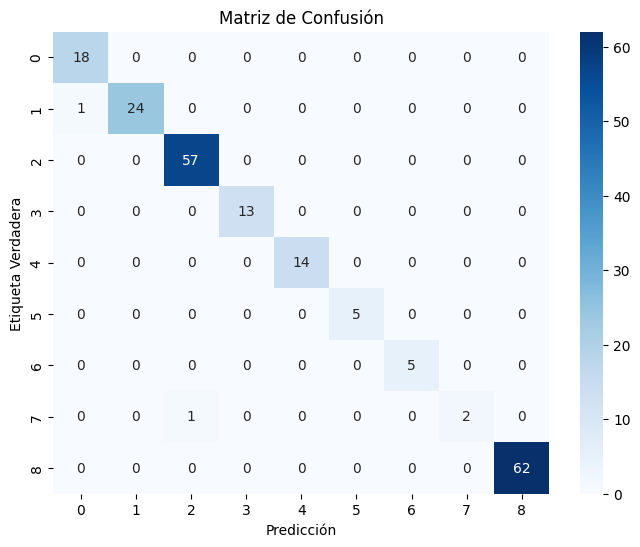

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Predecir las clases para el conjunto de pruebas
y_pred = np.argmax(classifier.predict(test_dataset), axis=1)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Generar matriz de confusión
confusion_mat = confusion_matrix(y_true, y_pred)

# Generar reporte de clasificación
class_names = ['0', '1', '2', '3', '4', '5', '6', '7','8']
classification_rep = classification_report(y_true, y_pred, target_names=class_names)

# Imprimir la matriz de confusión y el reporte de clasificación
print("Matriz de Confusión:")
print(confusion_mat)
print("\nReporte de Clasificación:")
print(classification_rep)

# Crear una figura
plt.figure(figsize=(8, 6))

# Crear el mapa de calor (heatmap) de la matriz de confusión
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

# Añadir etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')

# Mostrar la figura
plt.show()


In [ ]:
np.savetxt('matriz_de_confusion.csv', confusion_mat, delimiter=',')

# Guardar el reporte de clasificación en un archivo de texto
with open('reporte_de_clasificacion.txt', 'w') as file:
    file.write(classification_rep)

# ... (tu código para generar el gráfico)

# Guardar el gráfico en un archivo de imagen


# Mostrar la figura
plt.show()



In [ ]:
plt.savefig('matriz_de_confusion.jpg')

<Figure size 640x480 with 0 Axes>